In [1]:
import correlation_analysis as corr_anl
import matplotlib.pyplot as plt
import csv
import os
import numpy as np
import glob
import h5py
import matplotlib as mpl
import propagation_functions as prop
import cmocean
import cfd_processing
from tqdm import tqdm

from matplotlib.colors import LinearSegmentedColormap

res_path = "/Users/ultandaly/Desktop/tmp_analysis/"

figure_dir = "/Users/ultandaly/Library/CloudStorage/OneDrive-UniversityofGlasgow/Posters/top_conference/figures/"

screen_width = 0.25
res = 512
res_dir = 'comp_freq/'
delta = (screen_width/res) * 1000

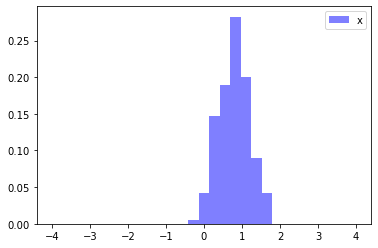

In [9]:
com_int_path = res_path + res_dir + 'com_int_test/'
files = os.listdir(com_int_path)
files = files[1:]

file_num = 3

arr = np.loadtxt(com_int_path + files[file_num], delimiter=',', dtype=float)
weights = np.ones_like(arr[:, 0])/len(arr)

bins = np.linspace(-4, 4, 30)
plt.hist((arr[:, 0] - 255.5) * delta, bins, weights = weights, alpha = 0.5, label = 'x', color='blue')
#plt.hist((arr[:, 1] - 255.5) * delta, bins, alpha = 0.5, label = 'y', color='green')
plt.legend(loc = 'upper right')
plt.show()


In [15]:
def get_com_array(filepath, filenum, dim, delta, res):

    files = glob.glob(filepath + '*.csv')

    cent_correction = res-1 /2
    arr = np.loadtxt(files[filenum], delimiter=',', dtype=float)
    arr_vals = (arr[:, dim] - 255.5)*delta
    
    return arr_vals


In [11]:
def get_spec(filepath, filenum, dim, delta, res):
    
    files = glob.glob(filepath + '*.csv')
    arr = np.loadtxt(filepath + files[filenum], delimiter=',', dtype=float)
    mean_spec = np.mean(arr, 0)
    norm_spec = mean_spec / np.sum(mean_spec)

    return norm_spec

In [12]:
def hist_plot(arrs, nbins, min, max, alpha, col, lbl, save_name = None):
    bins = np.linspace(min, max, nbins)

    for i, arr in enumerate(arrs):
        weights = np.ones_like(arr)/len(arr)
        plt.hist(arr, bins, weights = weights, color= col[i], label = lbl[i], alpha = alpha[i])
        plt.xlabel('COM Displacement (mm)')
        plt.ylabel('Prob.')
    
        #plt.legend(bbox_to_anchor = (1.04, 1),loc = 'upper left', prop={'size':18})
        #plt.legend(bbox_to_anchor=(0.5, 1.32), loc='upper center', prop= {'size':13})
        plt.legend(loc='upper right', prop = {'size':14})

    if save_name is not None:
        plt.savefig(save_name, bbox_inches = 'tight')

    plt.show()



In [13]:
res_dir = [res_path + 'comp_freq/', res_path + 'high_freq/', res_path + 'low_freq/']
res_dir.append(res_path + 'statistical_propagation_L0_0.125/')
res_dir.append(res_path + 'statistical_propagation_kol/')
res_dirs = [res_str + 'com_int_test/' for res_str in res_dir]

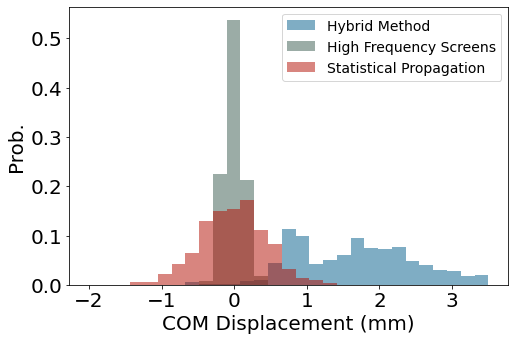

In [16]:
#MPL SETTINGS TO PLAY ABOUT WITH FOR FORMATTING
plt.rcParams['figure.figsize'] = (20/2.54, 13/2.54)

font = {'family': 'normal',
        'weight': 'normal',
        'size': 20}

mpl.rc('font', **font)

save_name = figure_dir + 'com_tracking_stat_hf_comp.png'

com_arrs = [get_com_array(dir, 0, 0, delta, res) for dir in [res_dirs[0], res_dirs[1]]]

com_arrs.append(get_com_array(res_dirs[3], 0, 0, delta, res))

colors = ['#005C8A', '#385A4F', '#B30C00', 'yellow', 'purple']

labels = ['Hybrid Method', 'High Frequency Screens', 'Statistical Propagation', 'L0 = 0.125', 'Kolmogorov']
alpha = [0.5, 0.5, 0.5, 0.6, 0.6]

hist_plot(com_arrs[:][0:401], 30, -2, 3.5, alpha, colors,
          labels, save_name)


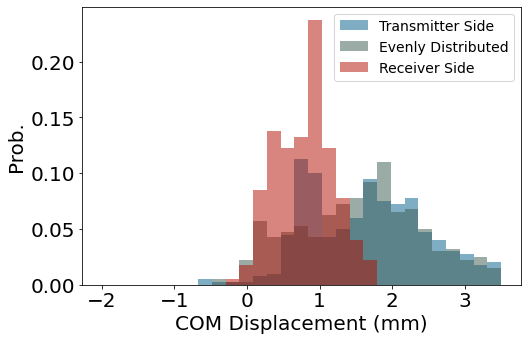

In [17]:
plt.rcParams['figure.figsize'] = (20/2.54, 13/2.54)

font = {'family': 'normal',
        'weight': 'normal',
        'size': 20}

mpl.rc('font', **font)

save_name = figure_dir + 'com_tracking_steps.png'

com_arrs = [get_com_array(res_dirs[0], i, 0, delta, res) for i in [0, 2, 3]]

colors = ['#005C8A', '#385A4F', '#B30C00', 'yellow', 'purple']
labels = ['Transmitter Side', 'Evenly Distributed',
          'Receiver Side', 'L0 = 0.125', 'Kolmogorov']
alpha = [0.5, 0.5, 0.5, 0.6, 0.6]

hist_plot(com_arrs, 30, -2, 3.5, alpha, colors,
          labels, save_name)


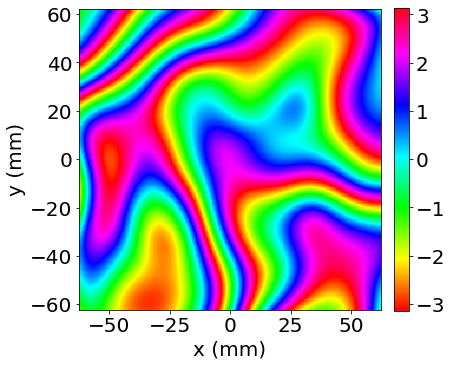

In [52]:
with h5py.File('/Volumes/Newton/V4_results/20230206/low_freq/timestamp_01650.h5', 'r') as f:
    keys = []
    f.visit(lambda key: keys.append(key) if isinstance(f[key], h5py.Dataset) else None)
    key = keys[2]
    beam = f[key][()]


plt.rcParams['figure.figsize'] = (15/2.54, 15/2.54)

font = {'family': 'normal',
        'weight': 'normal',
        'size': 20}


plt.imshow(np.angle(beam[128:256+128, 128:256 + 128]), extent = [ -127.5*delta, 127.5*delta, -127.5*delta, 127.5*delta], interpolation='none', cmap = 'hsv')
plt.colorbar(fraction = 0.046, pad = 0.04)

plt.xlabel('x (mm)')
plt.ylabel('y (mm)')

plt.savefig(figure_dir + 'low_freq_beam_phase.png', bbox_inches='tight')


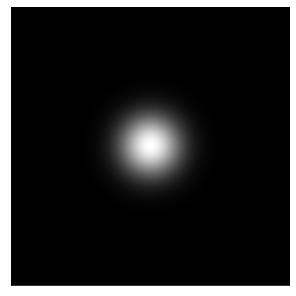

In [237]:
beam = prop.BeamProfile(res, 0.25, 1550*10**-9.0)
beam.laguerre_gaussian_beam(0, 0, 0.075/2)
plt.xticks([])
plt.yticks([])
plt.imshow(np.abs(beam.field) ** 2.0, cmap = 'gist_gray')
plt.savefig(figure_dir + 'expample_beam.png', bbox_inches='tight')


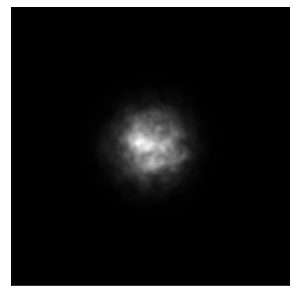

In [238]:
t = prop.PhaseScreen(screen_width, res, 0.1, 0.0001, 100.0)
t.mvk_sh_screen()
t.mvk_screen()
beam.apply_phase_screen(t.phz + t.phz_lo)
beam.free_space_prop(100)
plt.xticks([])
plt.yticks([])
plt.imshow(np.abs(beam.field) ** 2.0, cmap = 'gist_gray')
plt.savefig(figure_dir + 'expample_beam_perturb.png', bbox_inches='tight')

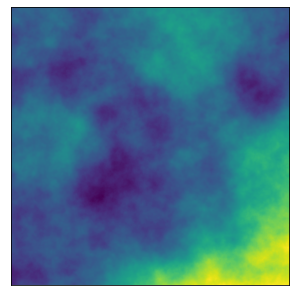

In [240]:
plt.xticks([])
plt.yticks([])
plt.imshow(t.phz + t.phz_lo)
plt.savefig(figure_dir + 'example_mvk_screen.png', bbox_inches='tight')


In [289]:

# Plot Screens

target_res = 512
dim_mult = 1

filt_point = 106.629
wavelength = 1550*10 ** -9.0
part_width = 20
pixel_width = 0.0125
avg_screens = 20
channel_length = 45
screen_num = 5

delz = avg_screens * pixel_width
cfd_file_path = '/Volumes/Newton/V4_results/python_formatting'

screens = [cfd_processing.cfdScreens(
    int(target_res), dim_mult, filt_point, wavelength, part_width, screen_width) for i in range(45)]

cfd_screens_channel = cfd_processing.cfdChannel(
        cfd_file_path, "h5", pixel_width, wavelength, part_width)


cfd_screens = np.ndarray( (channel_length, part_width, part_width))
cfd_screens_channel.get_opd_screens(avg_screens, 0, delz)
cfd_screens = np.asarray(cfd_screens_channel.opd_part)
screens[screen_num].interpolate_cfd(cfd_screens[screen_num])

with h5py.File('/Volumes/Newton/V4_results/20230206/hf_screens/timestamp_01500.h5', 'r') as f:
    keys = []
    f.visit(lambda key: keys.append(key) if isinstance(f[key], h5py.Dataset) else None)
    
    screens[screen_num].high_freq_phz = f[keys[screen_num - 3]][()]

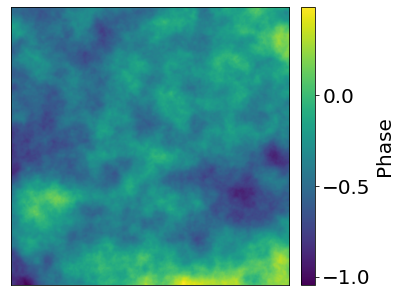

In [359]:
plt.xticks([])
plt.yticks([])
plt.imshow(screens[screen_num].low_freq_phz[0:512, 0:512] + screens[screen_num].high_freq_phz[0:512, 0:512])
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label('Phase')
plt.savefig(figure_dir + 'comp_freq_exp.png', bbox_inches='tight')


In [30]:
np.shape(screens[screen_num].high_freq_phz)

(2048, 2048)

In [34]:
# Plot Screens

target_res = 512
dim_mult = 1
filt_point = 106.629
wavelength = 1550*10 ** -9.0
part_width = 20
pixel_width = 0.0125
avg_screens = 20
channel_length = 45


screen_nums = [6, 15, 20, 29, 37]

delz = avg_screens * pixel_width
cfd_file_path = '/Volumes/Newton/V4_results/python_formatting'

save_phz = np.ndarray((5, 500, part_width, part_width))

for ii, screen_num in enumerate(screen_nums):
    screens = [cfd_processing.cfdScreens(
    part_width, dim_mult, filt_point, wavelength, part_width, screen_width) for i in range(500)]

    cfd_screens_channel = cfd_processing.cfdChannel(
        cfd_file_path, "h5", pixel_width, wavelength, part_width)


    cfd_screens = np.ndarray( (channel_length, part_width, part_width))

    for time in tqdm(range(500)):
        cfd_screens_channel.get_opd_screens(avg_screens, time, delz)
        cfd_screens = np.asarray(cfd_screens_channel.opd_part)
        #screens[screen_num].interpolate_cfd(cfd_screens[screen_num])
        save_phz[ii, time] = cfd_screens[screen_num]

100%|██████████| 500/500 [09:18<00:00,  1.12s/it]


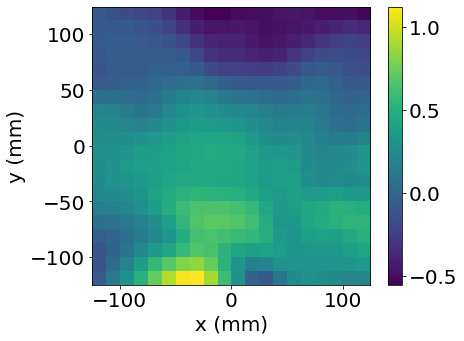

In [234]:
plt.imshow(np.mean(save_phz[1, 0:400], 0),  extent = [-255.5*delta, 255.5*delta, -255.5*delta, 255.5*delta])
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')

plt.colorbar(fraction=0.046, pad=0.04)
plt.savefig( figure_dir+ 'correlation_example.png' , bbox_inches = 'tight')

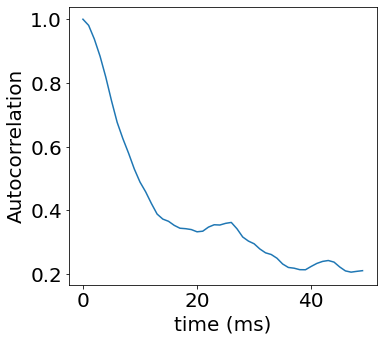

In [482]:
auto_corr= [corr_anl.img_list_autocovariance(save_phz[0 + 50*i:50*(i+1)], 0, np.zeros_like(save_phz[0])) for i in range (10)]

plt.rcParams['figure.figsize'] = (14/2.54, 13/2.54)

plt.plot(np.mean(auto_corr, 0))
plt.ylabel('Autocorrelation')
plt.xlabel('time (ms)')
plt.savefig(figure_dir + 'correlation_plot.png', bbox_inches='tight')

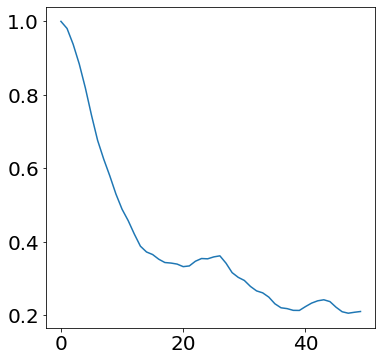

In [465]:
plt.plot(np.mean(auto_corr, 0))

In [276]:
beam_dir = '/Volumes/Newton/V4_results/20230210/fixed_time_ev_4_secs/comp_freq/'
beam_files = os.listdir(beam_dir)
beam_files = beam_files[0:-1:2]
unperturbed = prop.BeamProfile(512, 0.25, 1550 * 10 **-9.0)
unperturbed.laguerre_gaussian_beam(0, 0, 0.075/2)
unperturbed.free_space_prop(80)



corr = np.ndarray((5, 50))
for j in range(5):
    sc = np.ndarray((50, 512, 512))
    for i in tqdm(range(50)):
        with h5py.File(beam_dir + beam_files[i + j * 5], 'r') as f:
            keys = []
            f.visit(lambda key: keys.append(key) if isinstance(f[key], h5py.Dataset) else None)
            #print(keys[1])
            #key = keys[2]
            sc[i] = np.abs(f[keys[2]][()])**2.0
    
    corr[j, :] = corr_anl.img_list_autocovariance(
        sc, 0, np.abs(unperturbed.field) ** 2.0)


100%|██████████| 50/50 [00:00<00:00, 239.52it/s]


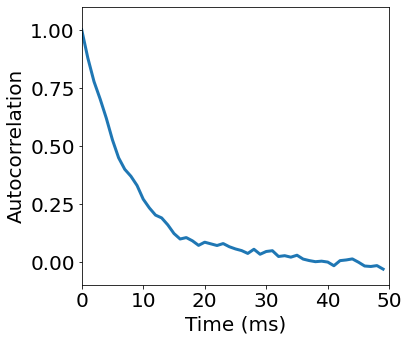

In [287]:
unperturbed = prop.BeamProfile(512, 0.25, 1550 * 10 **-9.0)
unperturbed.laguerre_gaussian_beam(0, 0, 0.075/2)
unperturbed.free_space_prop(80)

plt.rcParams['figure.figsize'] = (14/2.54, 13/2.54)

plt.plot(np.mean(corr, 0), linewidth = 3.0)
plt.ylabel('Autocorrelation')
plt.xlabel('Time (ms)')
plt.xlim([0, 50])
plt.ylim([-0.1, 1.1])
plt.savefig(figure_dir + 'auto_correlation_plot.png', bbox_inches='tight')


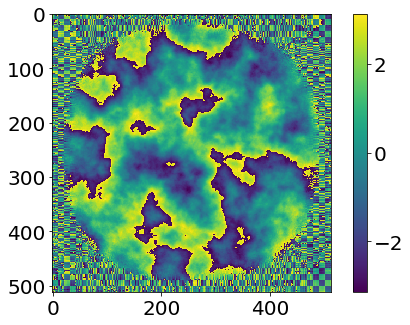

In [261]:
plt.imshow(sc[5], interpolation='none')
plt.colorbar()

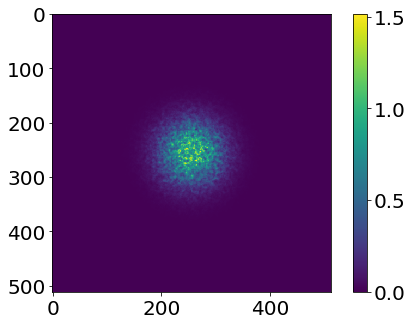

In [229]:
plt.imshow(sc[8], interpolation='none')
plt.colorbar()

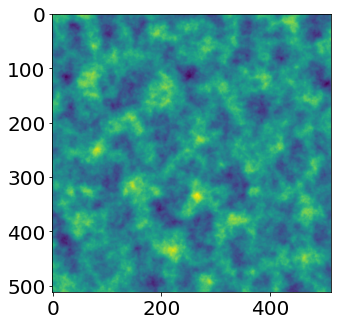

In [180]:
with h5py.File('/Volumes/Newton/V4_results/20230210/one_cell_tst/high_freq/timestamp_0150hf_screen.h5', 'r') as f:
    keys = []
    f.visit(lambda key: keys.append(key) if isinstance(f[key], h5py.Dataset) else None)
    screen = f[keys[0]][()]
    plt.imshow(screen)

In [385]:
with h5py.File('/Volumes/Newton/V4_results/20230210/fixed_time_ev_4_secs/comp_freq/timestamp_01755.h5','r') as f:
    keys = []
    f.visit(lambda key: keys.append(key) if isinstance(
        f[key], h5py.Dataset) else None)
    print(keys)
    key = keys[0]
    b = f[key][()]


['beam_profile_l_00/[0.0_0.0_0.0_0.0_40.0]', 'beam_profile_l_00/[0_13.33333_13.33333_13.3333_0]', 'beam_profile_l_00/[40.0_0.0_0.0_0.0_0.0]', 'beam_profile_l_01/[0.0_0.0_0.0_0.0_40.0]', 'beam_profile_l_01/[0_13.33333_13.33333_13.3333_0]', 'beam_profile_l_01/[40.0_0.0_0.0_0.0_0.0]']


Text(0, 0.5, 'y (mm)')

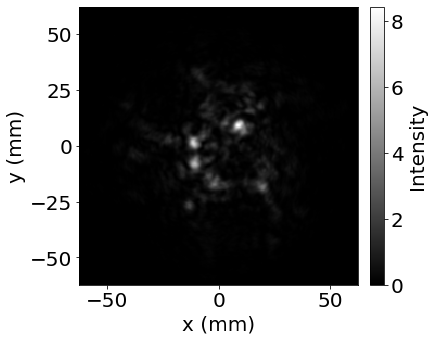

In [386]:

plt.imshow(np.abs(b[128:256 + 129, 128: 256 + 129])**2.0, cmap='gist_gray', extent=[-127.5*delta, 127.5*delta, -127.5*delta, 127.5*delta], interpolation='none')
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label('Intensity')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
#plt.savefig(figure_dir + 'time_ev_15.png', bbox_inches='tight')


In [6]:
working_dir = "/Volumes/Newton/V4_results/20230210/"
files = glob.glob(working_dir + 'fixed_time_ev_4_secs/comp_freq/'+ '*.h5')

arr = np.ndarray((250, 256, 256))

for i in range(250):
    with h5py.File(files[i], 'r') as f:
        keys = []
        f.visit(lambda key: keys.append(key) if isinstance(
        f[key], h5py.Dataset) else None)
        data = f[keys[1]][()]
    arr[i] = np.abs(data[128:256 + 128, 128:256 + 128]) ** 2.0       


In [7]:
np.max(arr)

10.939224330097383

In [407]:
files = glob.glob(working_dir + 'fixed_time_ev_4_secs/comp_freq/'+ '*.h5')

In [427]:
del plt.xticks
del plt.yticks